In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import random
from sklearn.model_selection import train_test_split
import shutil
%matplotlib inline

In [2]:
"""shutil.rmtree('liver_seg')"""

"shutil.rmtree('liver_seg')"

In [3]:
#Create paths for liver segmentation
liver_seg = 'liver_seg'
os.mkdir(liver_seg)
train_liver_seg = os.path.join(liver_seg, 'train')
os.mkdir(train_liver_seg)
valid_liver_seg = os.path.join(liver_seg, 'valid')
os.mkdir(valid_liver_seg)
train_liver_images = os.path.join(train_liver_seg, 'Images')
os.mkdir(train_liver_images)
train_images = os.path.join(train_liver_images, 'images')
os.mkdir(train_images)
train_liver_masks = os.path.join(train_liver_seg, 'Masks')
os.mkdir(train_liver_masks)
train_masks = os.path.join(train_liver_masks, 'masks')
os.mkdir(train_masks)
valid_liver_images = os.path.join(valid_liver_seg, 'Images')
os.mkdir(valid_liver_images)
valid_images = os.path.join(valid_liver_images, 'images')
os.mkdir(valid_images)
valid_liver_masks = os.path.join(valid_liver_seg, 'Masks')
os.mkdir(valid_liver_masks)
valid_masks = os.path.join(valid_liver_masks, 'masks')
os.mkdir(valid_masks)

In [4]:
train_mask_path = '../input/litsbalanceddatasets/balanced-datasets/liver/train/liver_seg/liver_seg/'
train_ct_path = '../input/litsbalanceddatasets/balanced-datasets/liver/train/ct/ct'
train_mask = './liver_seg/train/Masks/masks'
train_ct = './liver_seg/train/Images/images'
valid_mask_path = '../input/litsbalanceddatasets/balanced-datasets/liver/valid/liver_seg/liver_seg/'
valid_ct_path = '../input/litsbalanceddatasets/balanced-datasets/liver/valid/ct/ct'
valid_mask = './liver_seg/valid/Masks/masks'
valid_ct = './liver_seg/valid/Images/images'
train_files = os.listdir(train_mask_path)
valid_files = os.listdir(valid_mask_path)

In [5]:
train_liver = []
train_non_liver = []
for file_name in train_files:
    slice = cv2.imread(os.path.join(train_mask_path, file_name))
    if slice.sum() != 0:
        train_liver.append(file_name)
    else:
        train_non_liver.append(file_name)
print('Number of liver slices:', len(train_liver))
print('Number of non liver slices:', len(train_non_liver))

Number of liver slices: 13419
Number of non liver slices: 13419


In [6]:
random.shuffle(train_liver)
random.shuffle(train_non_liver)
train_liver_slices = train_liver[:4000] + train_non_liver[:4000]
random.shuffle(train_liver_slices)

In [7]:
valid_liver = []
valid_non_liver = []
for file_name in valid_files:
    slice = cv2.imread(os.path.join(valid_mask_path, file_name))
    if slice.sum() != 0:
        valid_liver.append(file_name)
    else:
        valid_non_liver.append(file_name)
print('Number of liver slices:', len(valid_liver))
print('Number of non liver slices:', len(valid_non_liver))

Number of liver slices: 2573
Number of non liver slices: 2573


In [8]:
random.shuffle(valid_liver)
random.shuffle(valid_non_liver)
valid_liver_slices = valid_liver[:1000] + valid_non_liver[:1000]
random.shuffle(valid_liver_slices)

In [9]:
for seg_file in train_liver_slices:
    ct_file = seg_file.replace('segmentation', 'volume')
    mask = cv2.imread(os.path.join(train_mask_path, seg_file), cv2.IMREAD_GRAYSCALE)
    cv2.imwrite(os.path.join(train_mask, seg_file), mask)

    image = cv2.imread(os.path.join(train_ct_path, ct_file))
    cv2.imwrite(os.path.join(train_ct, ct_file), image) 

for seg_file in valid_liver_slices:
    ct_file = seg_file.replace('segmentation', 'volume')
    mask = cv2.imread(os.path.join(valid_mask_path, seg_file), cv2.IMREAD_GRAYSCALE)
    cv2.imwrite(os.path.join(valid_mask, seg_file), mask)

    image = cv2.imread(os.path.join(valid_ct_path, ct_file))
    cv2.imwrite(os.path.join(valid_ct, ct_file), image) 

In [10]:
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.compat.v1 import image
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, UpSampling2D, Conv2DTranspose, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Lambda
from tensorflow.keras.layers import BatchNormalization, Activation, concatenate, multiply, add
from tensorflow.keras.layers import ReLU, LeakyReLU, PReLU, ELU, Softmax
from tensorflow.keras.activations import sigmoid

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
from cv2 import imread, createCLAHE 
from glob import glob

from IPython.display import clear_output
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import train_test_split

In [12]:
from tensorflow.keras.models import *
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import layers

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)
def iou_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (keras.sum(y_true_f) + keras.sum(y_pred_f) - intersection + 1.0)

In [13]:
def unet(input_size=(512,512,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [14]:
def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = (img - img.min()) / (img.max() - img.min())
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = (img - img.min()) / (img.max() - img.min())
        mask = mask / 255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img, mask)

def trainGenerator(batch_size,train_path,image_folder,
                   mask_folder,
                   aug_dict,
                   image_color_mode = "grayscale",
                   mask_color_mode = "grayscale",
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   flag_multi_class = False,
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (512, 512),
                   seed = 1,
                   subset = 'training'):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed,
        subset = subset)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed,
        subset = subset)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)

In [15]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    shear_range=0.05,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest',
                    validation_split=0)


train_generator = trainGenerator(8,'./liver_seg/train','Images','Masks',data_gen_args,save_to_dir = None,
                                target_size = (512,512))
valid_generator = trainGenerator(8,'./liver_seg/valid','Images','Masks',data_gen_args,save_to_dir = None,
                                target_size = (512,512))

In [16]:
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [17]:
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

Found 8000 images belonging to 1 classes.
Found 8000 images belonging to 1 classes.


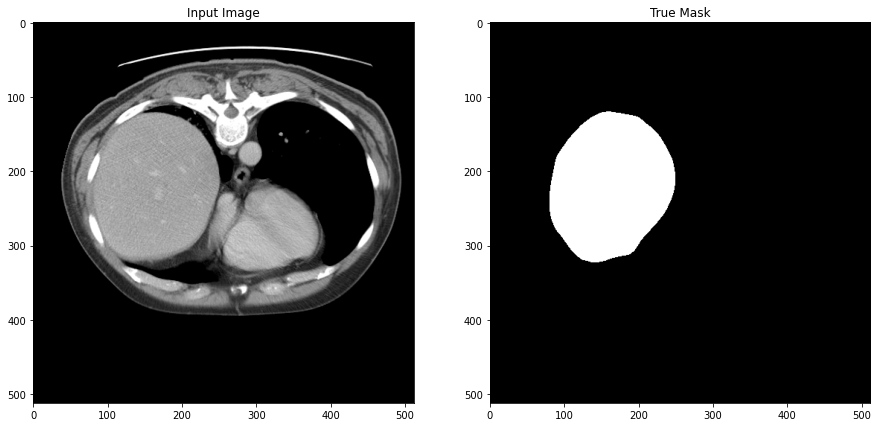

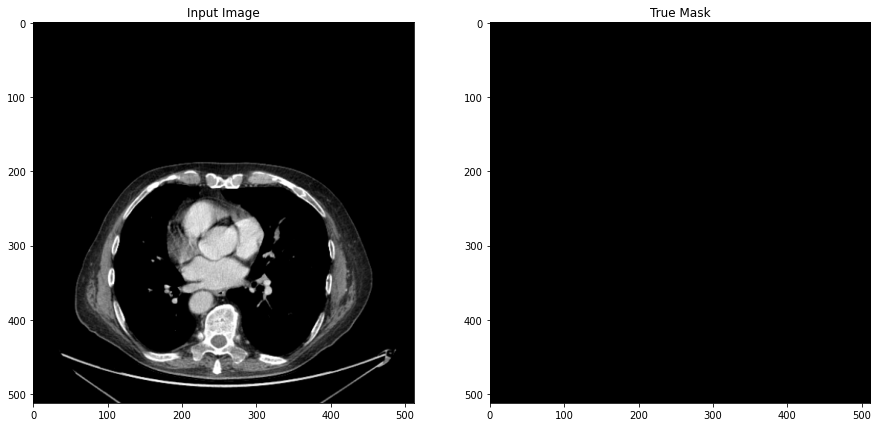

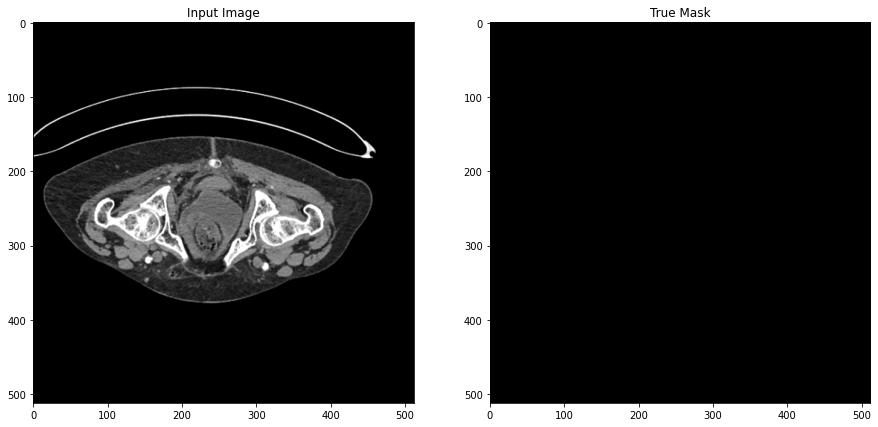

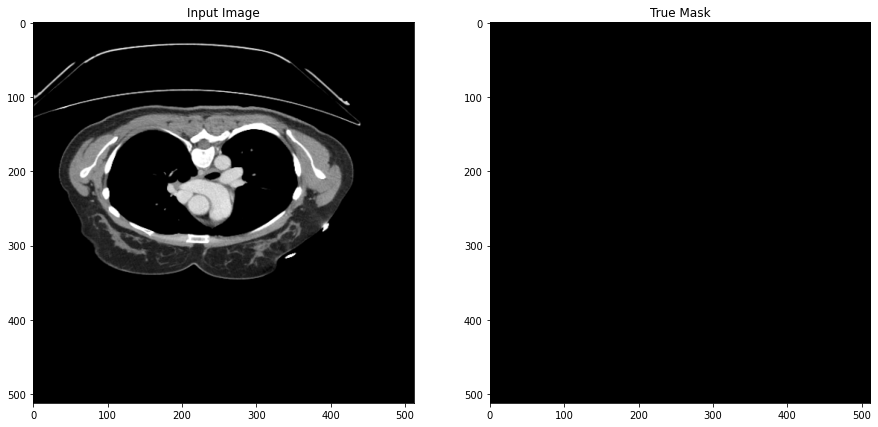

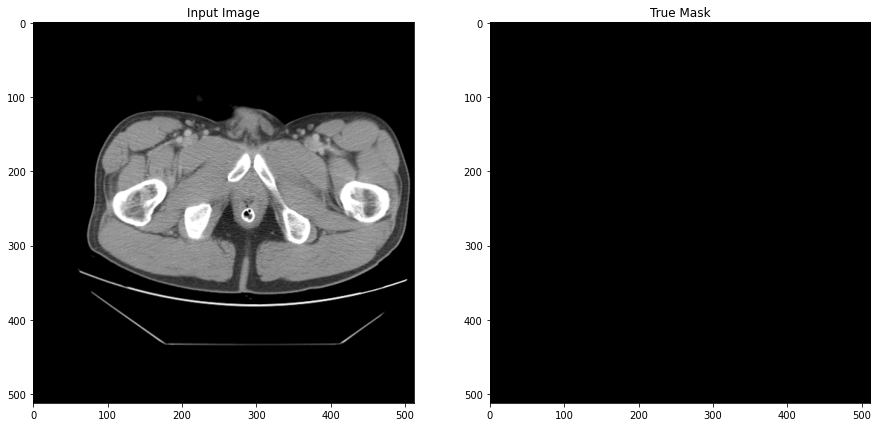

In [18]:
show_dataset(train_generator, 5)

Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.


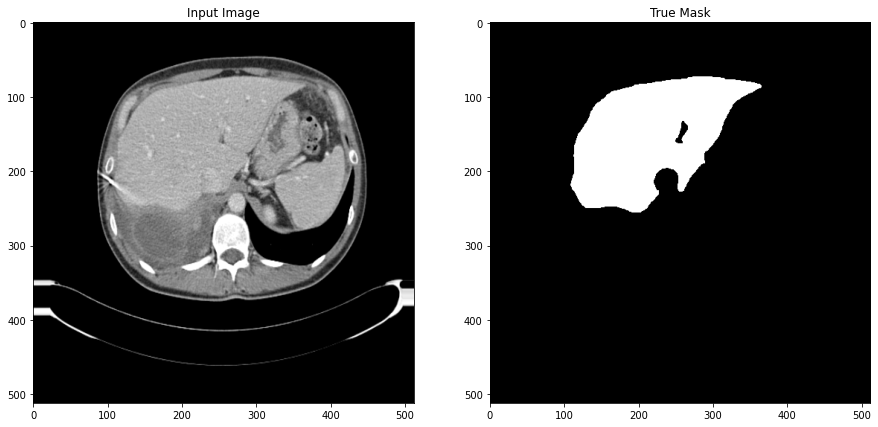

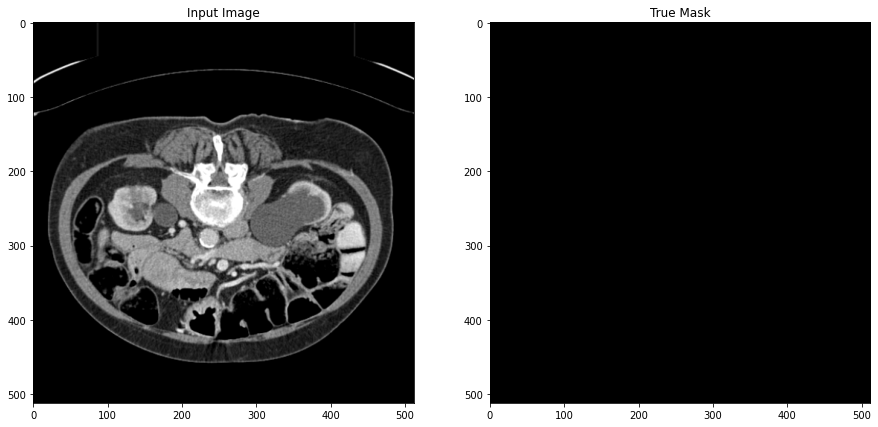

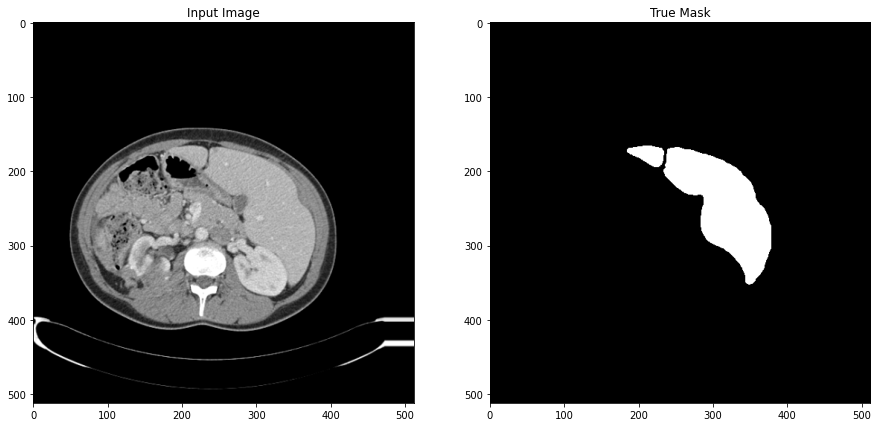

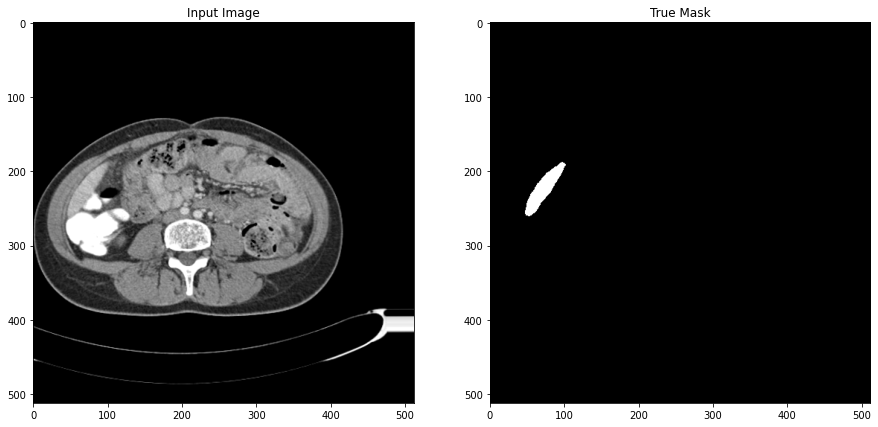

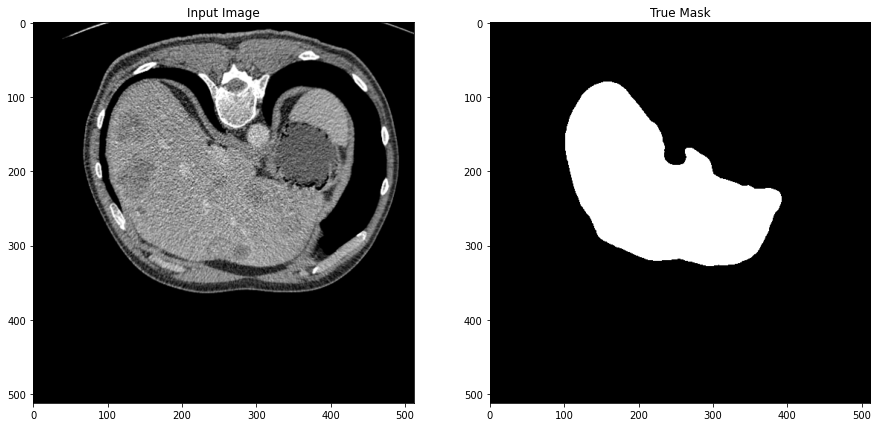

In [19]:
show_dataset(valid_generator, 5)

In [20]:
model = unet(input_size=(512,512,1))
model.summary()

2022-05-26 18:06:01.327090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 18:06:01.488976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 18:06:01.490135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 18:06:01.491779: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [21]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, iou_coef])

In [22]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights_best.hdf5".format('liver')

model_checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

model_tensorboard = TensorBoard('./', write_graph=True, write_images=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-08)
model_earlystop = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited

model_callbacks = [model_checkpoint,
                   model_tensorboard,
                   reduce_lr,
                   model_earlystop]

2022-05-26 18:06:05.085186: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-26 18:06:05.085230: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-05-26 18:06:05.087790: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-05-26 18:06:05.322656: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-26 18:06:05.322895: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [23]:
num_train = 8000
num_valid = 2000

train_batchsize = 8
valid_batchsize = 8

Step_train = num_train // train_batchsize
Step_valid = num_valid // valid_batchsize
epochs = 100

In [24]:
history = model.fit(train_generator,
                    steps_per_epoch=Step_train,
                    epochs=epochs,
                    validation_data=valid_generator,
                    validation_steps=Step_valid,
                    verbose=1,
                    callbacks=model_callbacks)

2022-05-26 18:06:05.996136: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-05-26 18:06:09.347458: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


   1/1000 [..............................] - ETA: 3:51:48 - loss: 0.9304 - dice_coef: 0.0696 - iou_coef: 0.0360

2022-05-26 18:06:19.997372: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-26 18:06:19.997553: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/1000 [..............................] - ETA: 10:31 - loss: 0.9488 - dice_coef: 0.0512 - iou_coef: 0.0264  

2022-05-26 18:06:20.590909: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-05-26 18:06:20.592456: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-05-26 18:06:20.748410: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 491 callback api events and 487 activity events. 
2022-05-26 18:06:20.777891: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-26 18:06:20.809694: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./train/plugins/profile/2022_05_26_18_06_20

2022-05-26 18:06:20.820328: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./train/plugins/profile/2022_05_26_18_06_20/6b998e6d29d0.trace.json.gz
2022-05-26 18:06:20.860254: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./train/plugins/profi

1000/1000 [==============================] - 545s 532ms/step - loss: 0.5799 - dice_coef: 0.4201 - iou_coef: 0.3091 - val_loss: 0.3078 - val_dice_coef: 0.6922 - val_iou_coef: 0.5501

Epoch 00001: val_dice_coef improved from -inf to 0.69222, saving model to liver_weights_best.hdf5
Epoch 2/100
1000/1000 [==============================] - 590s 590ms/step - loss: 0.3166 - dice_coef: 0.6834 - iou_coef: 0.5374 - val_loss: 0.3142 - val_dice_coef: 0.6858 - val_iou_coef: 0.5392

Epoch 00002: val_dice_coef did not improve from 0.69222
Epoch 3/100
1000/1000 [==============================] - 593s 594ms/step - loss: 0.2855 - dice_coef: 0.7145 - iou_coef: 0.5759 - val_loss: 0.2744 - val_dice_coef: 0.7256 - val_iou_coef: 0.5866

Epoch 00003: val_dice_coef improved from 0.69222 to 0.72558, saving model to liver_weights_best.hdf5
Epoch 4/100
1000/1000 [==============================] - 596s 596ms/step - loss: 0.2793 - dice_coef: 0.7207 - iou_coef: 0.5857 - val_loss: 0.2969 - val_dice_coef: 0.7031 - val

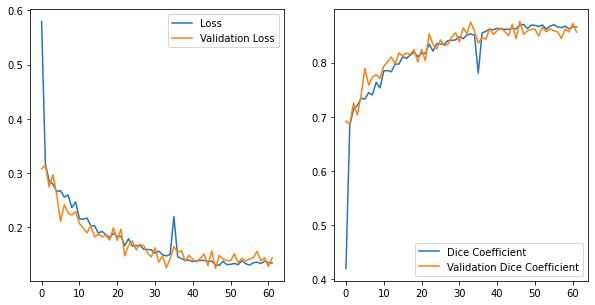

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(history.history['loss'], '-', label = 'Loss')
ax1.plot(history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(np.array(history.history['dice_coef']), '-', 
         label = 'Dice Coefficient')
ax2.plot(np.array(history.history['val_dice_coef']), '-',
         label = 'Validation Dice Coefficient')
ax2.legend()

In [26]:
log = 'log'
os.mkdir(log)

In [27]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = './log/history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = './log/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)